# Predicting Song Genres

## Initial attempt
* Try to predict the genres using only the numerical features

In [1]:
import pandas as pd
pd.options.display.max_columns = 200

songs = pd.read_csv('data/spotify_data.csv', index_col=[0])
songs.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Before cleaning the data

In [2]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

### After cleaning the data

In [3]:
songs = songs.drop_duplicates(['track_name','artists'])
# Drop rows with missing values
songs.dropna(inplace=True)
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81343 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          81343 non-null  object 
 1   artists           81343 non-null  object 
 2   album_name        81343 non-null  object 
 3   track_name        81343 non-null  object 
 4   popularity        81343 non-null  int64  
 5   duration_ms       81343 non-null  int64  
 6   explicit          81343 non-null  bool   
 7   danceability      81343 non-null  float64
 8   energy            81343 non-null  float64
 9   key               81343 non-null  int64  
 10  loudness          81343 non-null  float64
 11  mode              81343 non-null  int64  
 12  speechiness       81343 non-null  float64
 13  acousticness      81343 non-null  float64
 14  instrumentalness  81343 non-null  float64
 15  liveness          81343 non-null  float64
 16  valence           81343 non-null  float64
 1

### Fit model

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

X = songs.drop(columns = ["track_id", "artists", "album_name", "track_name", "track_genre"])
y = songs["track_genre"]
# Numerically encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Using stratify might help because we have an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, 
                                                    stratify=y_encoded, random_state=100)
# Train model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

### Evaluate performance

In [5]:
# Evaluate model
predictions = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.24924703423689226


In [6]:
# Get more detailed performance information for each class
f1 = f1_score(y_test, predictions, average=None)
class_to_f1 = dict(zip(label_encoder.classes_, f1))
# Sort f1-score in descending order
class_to_f1 = dict(sorted(class_to_f1.items(), key=lambda item: item[1], reverse=True))
class_to_f1

{'grindcore': 0.774869109947644,
 'comedy': 0.768831168831169,
 'sleep': 0.7154046997389034,
 'honky-tonk': 0.6168831168831168,
 'study': 0.6025974025974026,
 'romance': 0.5722543352601156,
 'iranian': 0.5676392572944297,
 'kids': 0.5653333333333334,
 'black-metal': 0.5179487179487179,
 'salsa': 0.46900269541778977,
 'drum-and-bass': 0.46428571428571425,
 'tango': 0.46408839779005523,
 'chicago-house': 0.45989304812834225,
 'detroit-techno': 0.4509283819628648,
 'classical': 0.43853820598006643,
 'hardstyle': 0.4367816091954023,
 'pagode': 0.42042042042042044,
 'new-age': 0.4120603015075377,
 'idm': 0.37362637362637363,
 'minimal-techno': 0.35294117647058826,
 'forro': 0.3506849315068493,
 'j-idol': 0.34582132564841495,
 'breakbeat': 0.34332425068119893,
 'sertanejo': 0.33749999999999997,
 'piano': 0.32764505119453924,
 'j-dance': 0.32727272727272727,
 'disney': 0.3244680851063829,
 'happy': 0.3224043715846994,
 'pop-film': 0.3170731707317073,
 'trance': 0.3115942028985507,
 'gospel': 

In [12]:
grouped_by_genre = songs.groupby(['track_genre']).size()
genre_count = grouped_by_genre.sort_values(ascending=False)
count = list()
for genre in class_to_f1.keys():
    count.append(genre_count[genre])
predictions_df = pd.DataFrame([], columns=['genre', 'f1-score', 'count'])
predictions_df['genre'] = class_to_f1.keys()
predictions_df['f1-score'] = class_to_f1.values()
predictions_df['count'] = count
display(predictions_df)

,genre,f1-score,count
0,grindcore,0.821705,965
1,comedy,0.797954,987
2,sleep,0.721053,945
3,honky-tonk,0.590476,826
4,kids,0.558011,939
...,...,...,...
108,metal,0.023256,213
109,alternative,0.000000,238
110,indie,0.000000,107
111,reggae,0.000000,166


Worse performing classes seem to be the ones with lower number of samples

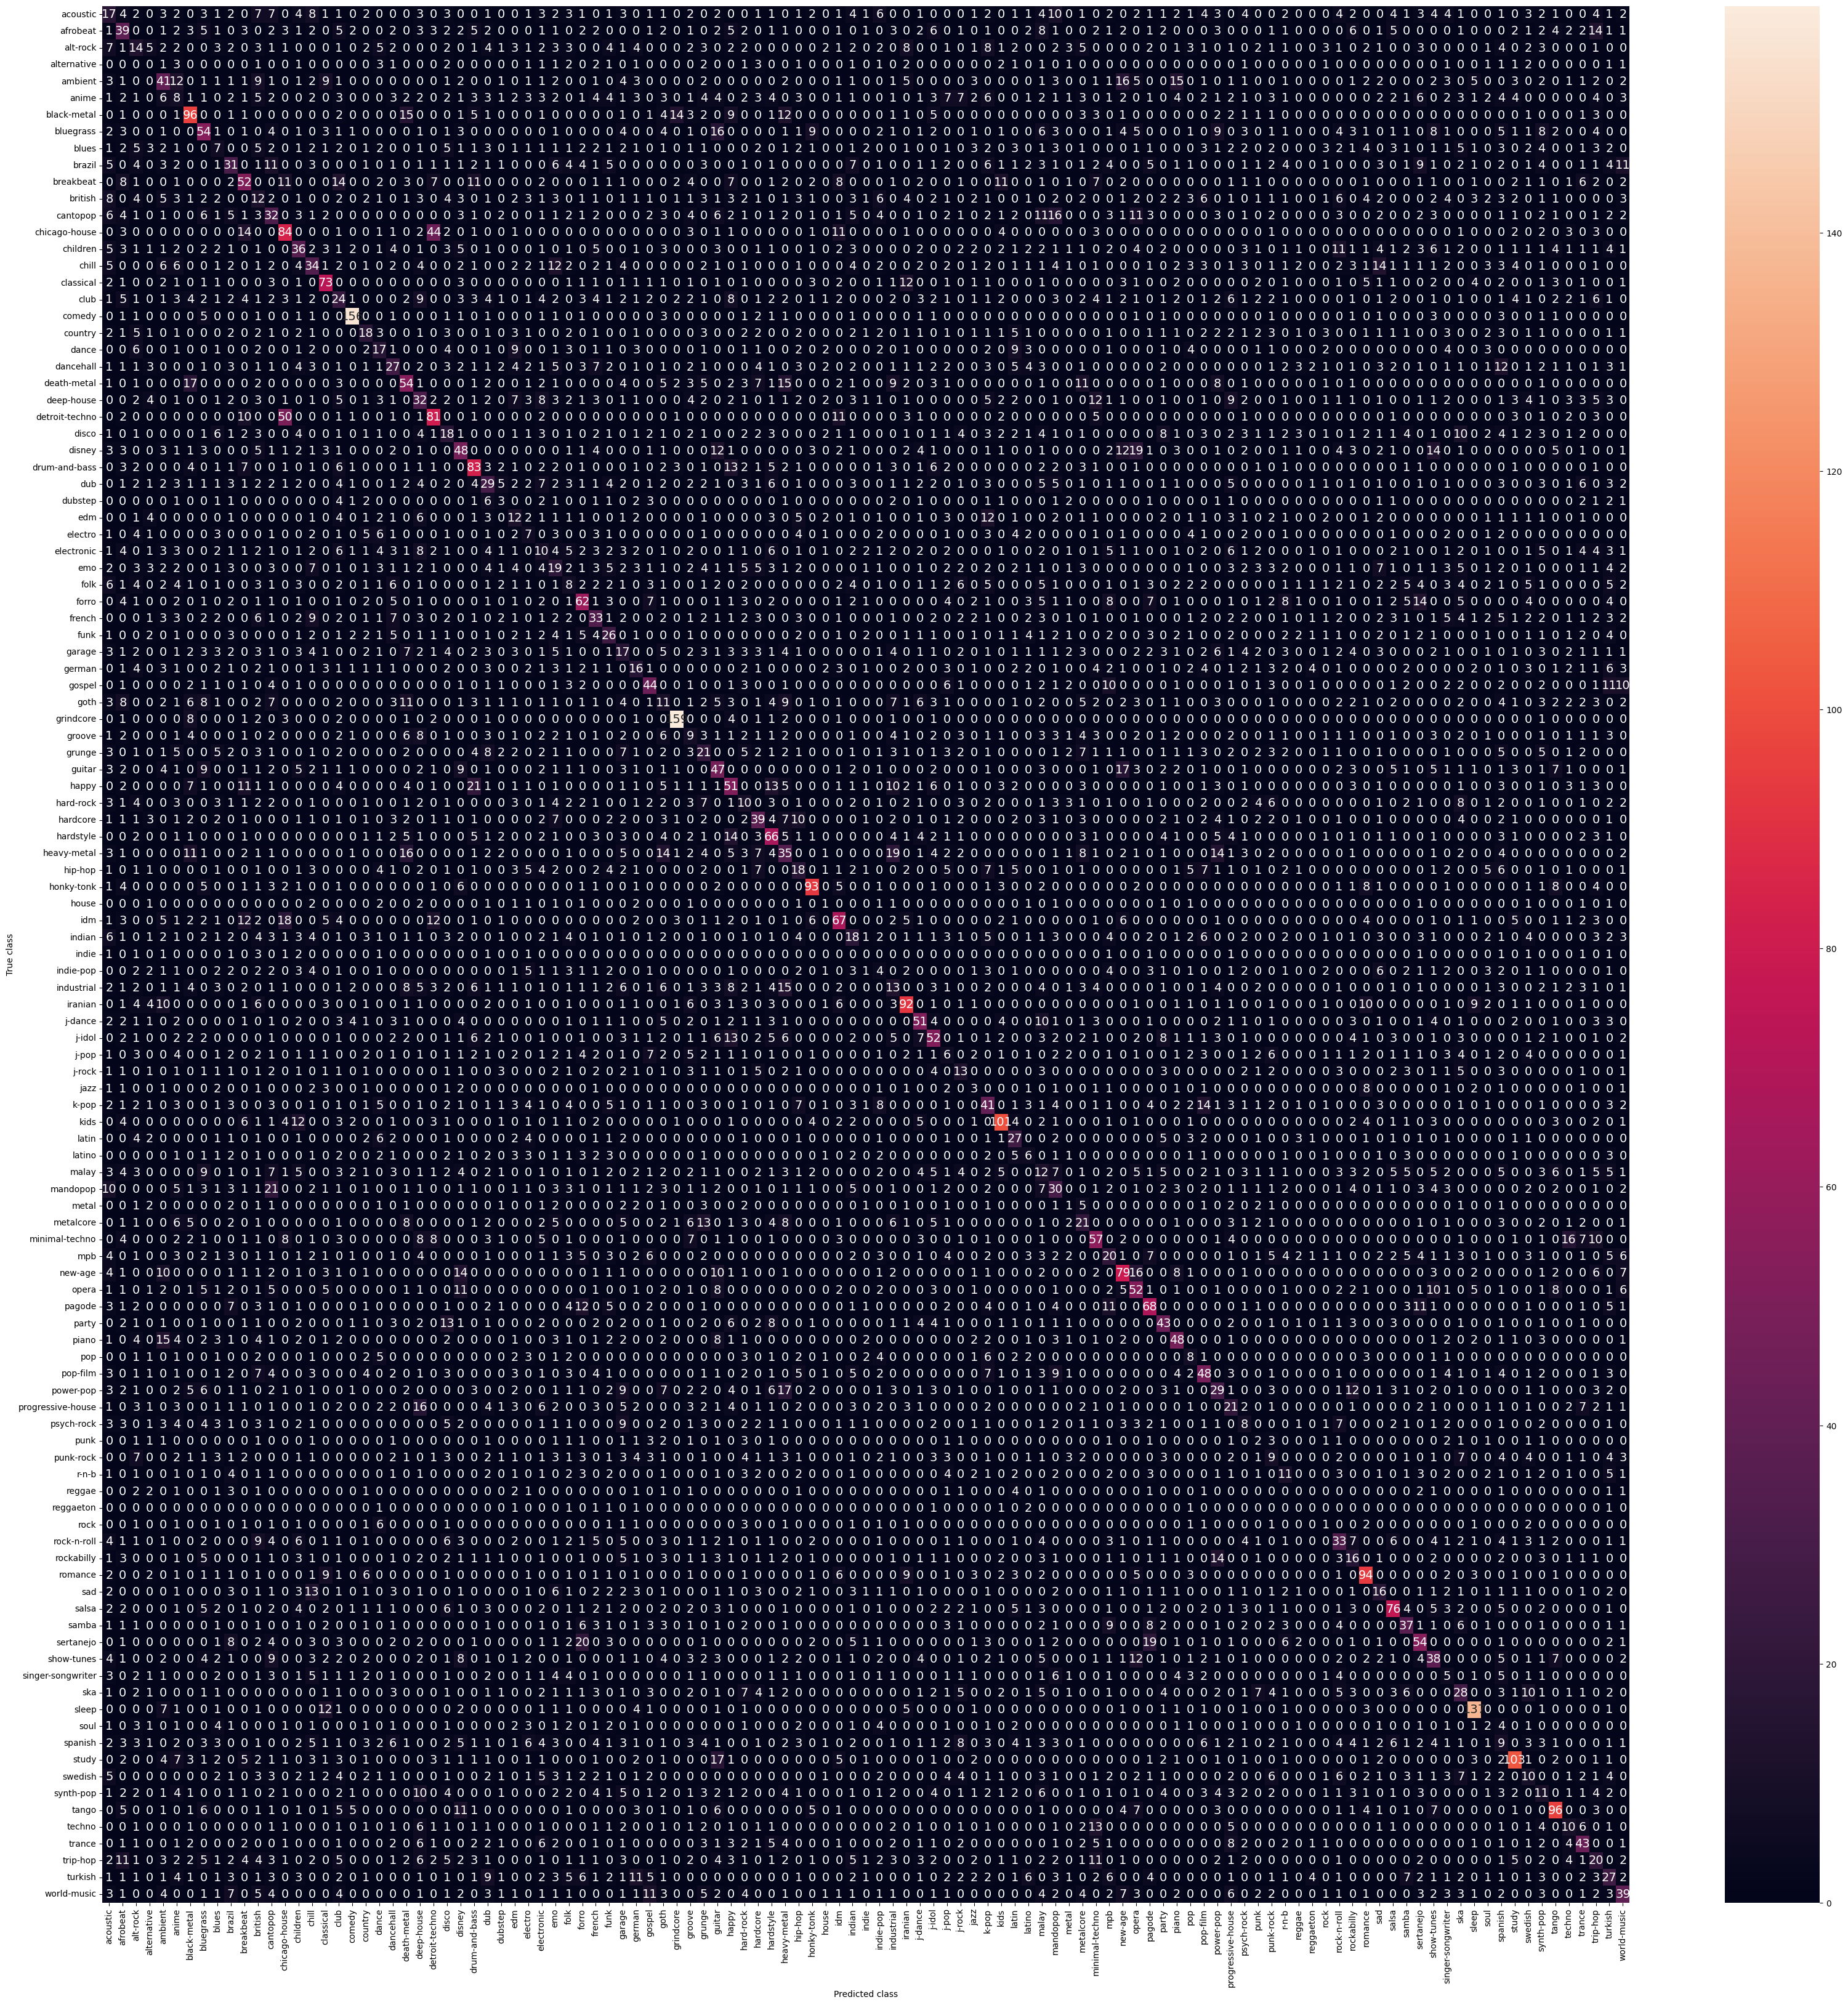

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [40, 40]
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
heatmap = sns.heatmap(cm_df, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.show()

Confusion matrix is huge and hard to read because there's more than 100 genres we are trying to predict

Some insights from the confusion matrix:
- The model predicted _ambient_ 15 times when the real class was _piano_
- There were alot of mixups between the electronic music genres
    - The model predicted often _deep house_ when the true classes were _synth pop_ and _progressive house_
    - Model predicted 50 times _chicago house_ when the song was actually _detroit techno_
        - Almost the same scenario vice-versa: 44 predictions for _detroit techno_ when song was _chicago house_
    - Same case for _techno_ and _minimal techno_

## Experiment #1: Balancing
* Try to overcome the class imbalance problem by using under or over sampling

### Undersampling

In [9]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

sampler = RandomUnderSampler()
decision_tree = DecisionTreeClassifier()
pipeline = Pipeline([('balancing', sampler), ('classifier', decision_tree)])
pipeline.fit(X_train, y_train)
# Evaluate model
predictions = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy using under sampling: {accuracy}")

Accuracy using under sampling: 0.17942098469481838


### Oversampling

In [10]:
sampler = RandomOverSampler()
decision_tree = DecisionTreeClassifier()
pipeline = Pipeline([('balancing', sampler), ('classifier', decision_tree)])
pipeline.fit(X_train, y_train)
# Evaluate model
predictions = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy using over sampling: {accuracy}")

Accuracy using over sampling: 0.2458663716270207


In [11]:
# Get more detailed performance information for each class
f1 = f1_score(y_test, predictions, average=None)
class_to_f1 = dict(zip(label_encoder.classes_, f1))
# Sort f1-score in descending order
class_to_f1 = dict(sorted(class_to_f1.items(), key=lambda item: item[1], reverse=True))
class_to_f1

{'grindcore': 0.821705426356589,
 'comedy': 0.7979539641943735,
 'sleep': 0.7210526315789473,
 'honky-tonk': 0.5904761904761904,
 'kids': 0.5580110497237568,
 'study': 0.5567567567567568,
 'romance': 0.5340909090909091,
 'tango': 0.5274725274725274,
 'iranian': 0.48936170212765956,
 'black-metal': 0.4752475247524752,
 'classical': 0.467948717948718,
 'detroit-techno': 0.4378378378378378,
 'drum-and-bass': 0.43569553805774275,
 'salsa': 0.43181818181818177,
 'chicago-house': 0.42748091603053434,
 'new-age': 0.41361256544502617,
 'pagode': 0.4121212121212121,
 'idm': 0.37640449438202245,
 'hardstyle': 0.352,
 'j-dance': 0.3517241379310345,
 'piano': 0.34657039711191334,
 'minimal-techno': 0.3413173652694611,
 'gospel': 0.33460076045627374,
 'sertanejo': 0.3312883435582822,
 'forro': 0.3297872340425532,
 'party': 0.3173431734317343,
 'death-metal': 0.31486880466472306,
 'trance': 0.3138686131386862,
 'samba': 0.3057851239669422,
 'opera': 0.30320699708454807,
 'pop-film': 0.29813664596273

### Experiment \#1 conclusion:
_Balancing doesn't seem to have much effect_